
# ADMT 2023 - Homework 4

## Group composition:


Grimaldi, Enrico, 1884443

Pandolfo, Mario Edoardo, 1835189


## Homework 4
The homework consists of two parts:

  1. Text Representation
  2. Deep Learning

# Part 1 - Find the best combination of Text Representation and Machine Learning Model

Import **ALL** the Python packages that you need for Part 1.

In [ ]:
!pip install -U sentence-transformers langdetect language_data langcodes simplemma

In [ ]:
import pandas as pd
import numpy as np
import nltk
from scipy import sparse
from langdetect import detect, DetectorFactory
from langcodes import Language
from time import time
from tqdm.auto import tqdm
import xgboost as xgb
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from typing import List, Set, Dict, Union
from collections import defaultdict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTETomek
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, auc, RocCurveDisplay, PrecisionRecallDisplay
#YOUR CODE ENDS HERE#
#THIS IS LINE 20#

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 36.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 120.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Part 1.1
The company **F**antastic **S**olution sells products. Customers can leave product reviews on their platform. The company wants to classify the reviews into positive and negative.

Their requirements are unclear: they mention both accuracy and calculation time, but it is not known which is more important to them. :'(

They also forbid you to do a hyper-parameter optimisation.
(why? :O )

To help you (?), they have already pre-processed the data. They have translated each text into a random language.

The best thing to do is to provide them with a list of models that can best meet their (unclear) requirements.

### 1.1.1
Download the data from the Drive link (code already provided).

In [ ]:
#REMOVE_OUTPUT#
!gdown 1X6QnCcOgnNEBQ1xnilmPWqDIs7bRrQof

Downloading...
From: https://drive.google.com/uc?id=1X6QnCcOgnNEBQ1xnilmPWqDIs7bRrQof
To: /content/FS_reviews.jsonl
100% 18.3M/18.3M [00:00<00:00, 117MB/s] 


### 1.1.2
Understand (!) and pre-process *(general term!)* the data.
Divide the data according to your needs.

> No specific request


In [ ]:
# Set the seed
seed = 709
DetectorFactory.seed = seed

# Read the dataset
data = pd.read_json('FS_reviews.jsonl', lines=True, orient='records')

# We take a look to the data
display(data.head())
display(data.info())

# We define the needed label
data['label'] = data['rating'].apply(lambda x: 0 if x < 3 else 1)

# Add review language to dataframe
data['iso639_code'] = data['review_text'].apply(detect)

# Get the full language name from the iso639 code
data['language'] = data['iso639_code'].apply(lambda code: Language.make(code).display_name().lower())

# Define the needed stopwords
stop_words = {}
for language in tqdm(data['language'].unique()):
  try:
    stop_words[language] = set(stopwords.words(language))
  except OSError as e:
    print(f"There are no stopwords available for '{language}', skipping...")

# Define the Tokenizer
tokenizer = RegexpTokenizer(r'[a-z]+')
# Define the needed stemmer
stemmers = {}
for language in tqdm(data['language'].unique()):
  try:
    stemmers[language] = SnowballStemmer(language)
  except ValueError as e:
    print(f"There is no nltk stemmer available for '{language}', skipping...")

,unique_id,product_name,product_type,helpful,rating,title,date,review_text,reviewer,reviewer_location
0,"B0007NOY3E:resperate_device:reith_r._busby_""rb...",RESPeRATE Blood Pressure Lowering Device: Heal...,health &amp; personal care,10 of 15,1,Resperate Device,2006-08-06,Expensive...and after three months of daily us...,"Reith R. Busby ""rbuzz""",Kansas City
1,B0007NOY3E:costs_too_much.:pmaclady,RESPeRATE Blood Pressure Lowering Device: Heal...,health &amp; personal care,14 of 64,1,Costs too much.,2006-04-19,Meditation will do the same thing. Buy a tape ...,PMacLady,Wisconsin
2,"B00006WNPY:don't_waste_your_money:l._reed_""mov...",Omron HJ-105 Pedometer with Calorie Counter: H...,health &amp; personal care,2 of 2,1,Don't Waste Your Money,2006-11-05,"When I got this pedometer, I found that the in...","L. Reed ""movie Buff""","Simi Valley, CA USA"
3,B00006WNPY:threw_away_$15.76:zoeeagleeye,Omron HJ-105 Pedometer with Calorie Counter: H...,health &amp; personal care,5 of 17,1,Threw away $15.76,2006-05-14,The pedometer arrive held prisoner in a diffic...,Zoeeagleeye,"Belfast, ME United States"
4,"B0009XH7KO:tasty,_but.....:catman","HOOAH! Energy Bars, Chocolate Crisp, 2.29-Ounc...",health &amp; personal care,13 of 16,2,"Tasty, But.....",2006-06-16,I was offered one of these while cycling and ...,Catman,"Oregon, USA"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20210 entries, 0 to 20209
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   unique_id          20210 non-null  object        
 1   product_name       20210 non-null  object        
 2   product_type       20210 non-null  object        
 3   helpful            20210 non-null  object        
 4   rating             20210 non-null  int64         
 5   title              20210 non-null  object        
 6   date               20200 non-null  datetime64[ns]
 7   review_text        20210 non-null  object        
 8   reviewer           20210 non-null  object        
 9   reviewer_location  20210 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 1.5+ MB


None

  0%|          | 0/14 [00:00<?, ?it/s]

There are no stopwords available for 'slovenian', skipping...
There are no stopwords available for 'afrikaans', skipping...
There are no stopwords available for 'somali', skipping...
There are no stopwords available for 'korean', skipping...
There are no stopwords available for 'polish', skipping...


  0%|          | 0/14 [00:00<?, ?it/s]

There is no nltk stemmer available for 'slovenian', skipping...
There is no nltk stemmer available for 'afrikaans', skipping...
There is no nltk stemmer available for 'catalan', skipping...
There is no nltk stemmer available for 'somali', skipping...
There is no nltk stemmer available for 'korean', skipping...
There is no nltk stemmer available for 'polish', skipping...


In [ ]:
# We define a function where we tokenize, remove stopwords and lemmatize each word
def preprocessing(text: str,
                  language: str,
                  tokenizer: RegexpTokenizer,
                  stop_words: Dict[str, Set[str]],
                  stemmers: Dict[str, SnowballStemmer],
                  threshold: int = 3) -> Union[List[str], None]:
  # We tokenize retrieving only the words
  tokens = tokenizer.tokenize(text.lower())

  # We remove the stopwords
  if stop_words.get(language):
    tokens =  list(filter(lambda w: w not in stop_words[language], tokens))

  # We remove the tokens smaller than the threshold
  tokens = [token for token in tokens if len(token) >= threshold]

  # If there are no tokens we return None
  if not tokens:
    return None

  # We perform the stemming
  if stemmers.get(language):
    tokens = [stemmers[language].stem(token) for token in tokens]

  return tokens

# Remove the rows where there was an error
data_no_errors = data[(data.review_text != 'ERROR')&(data.title != 'ERROR')].copy()

# Applying the preproccessing
start = time()
data_no_errors['tokens'] = data_no_errors.apply(lambda row: preprocessing(text=row.title + ' ' + row.review_text, language=row.language, tokenizer=tokenizer, stop_words=stop_words, stemmers=stemmers), axis=1)
end = time()
all_times = {'tokenization': end-start}

,title,review_text,tokens,label
0,Resperate Device,Expensive...and after three months of daily us...,"[resper, devic, expens, three, month, daili, u...",0
1,Costs too much.,Meditation will do the same thing. Buy a tape ...,"[cost, much, medit, thing, buy, tape, take, cl...",0
2,Don't Waste Your Money,"When I got this pedometer, I found that the in...","[wast, money, got, pedomet, found, instruct, c...",0
3,Threw away $15.76,The pedometer arrive held prisoner in a diffic...,"[threw, away, pedomet, arriv, held, prison, di...",0
4,"Tasty, But.....",I was offered one of these while cycling and ...,"[tasti, offer, one, cycl, thought, tasti, good...",0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17657 entries, 0 to 20209
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        17657 non-null  object
 1   review_text  17657 non-null  object
 2   tokens       17657 non-null  object
 3   label        17657 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 689.7+ KB


None

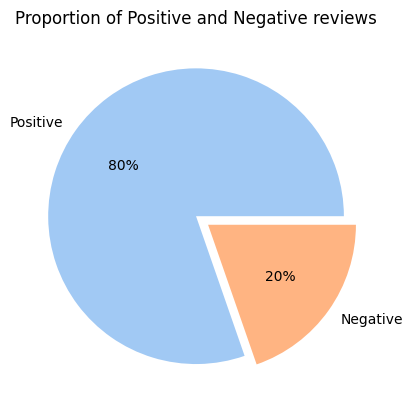

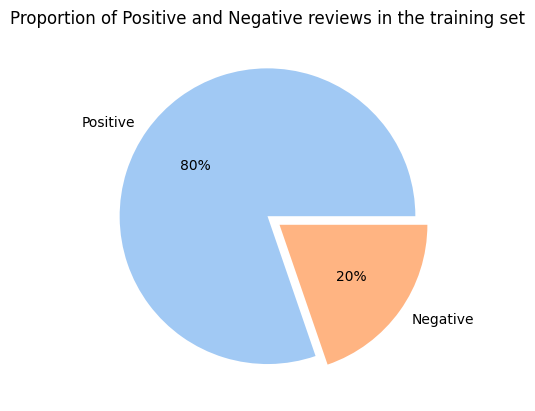

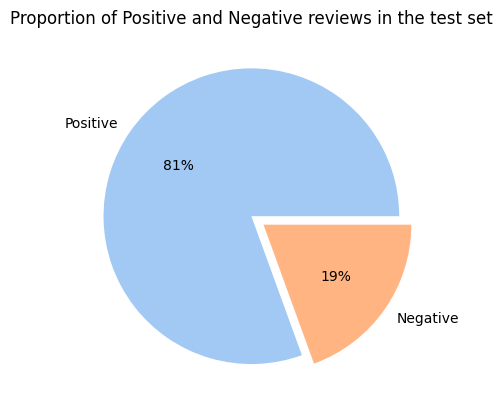

In [ ]:
# Get the meaningfull columns
df = data_no_errors[['title', 'review_text', 'tokens', 'label']].dropna()

# Drop the rows where we have less than 5 tokens in the review_text
df = df[df.tokens.apply(len) > 4]

# Display the data
display(df.head())
display(df.info())

# Show the proportions between the labels
colors = sns.color_palette('pastel')[0:2]
plt.pie(df['label'].value_counts(), labels=["Positive", "Negative"], colors = colors, autopct='%.0f%%', explode=[0, 0.1])
plt.title("Proportion of Positive and Negative reviews")
plt.show()

# Dividing in training and test dataframe
training_df, test_df = train_test_split(df, train_size=0.8, random_state=seed, shuffle=True)

print()
plt.pie(training_df['label'].value_counts(), labels=["Positive", "Negative"], colors = colors, autopct='%.0f%%', explode=[0, 0.1])
plt.title("Proportion of Positive and Negative reviews in the training set")
plt.show()

print()
plt.pie(test_df['label'].value_counts(), labels=["Positive", "Negative"], colors = colors, autopct='%.0f%%', explode=[0, 0.1])
plt.title("Proportion of Positive and Negative reviews in the test set")
plt.show()

Provide an explanation for your preprocessing *(general term!)* - **Use at most 3 sentences.**



[comment]: <> (#SHOW_CELL#)

We have decided to use the rating column to get the review label (negative if rating < 3, else positive) and to keep only the `review_text` and the `title` columns for the given task (we have notice that some rows have 'ERROR' as values in both columns, so we have dropped them).

In the preprocessing, being in the BoW assumption, we have merged the `title` with the `review_text`, then used a tokenizer that excludes special characters, symbols, and numbers (as they are reputed to be of little value for the meaningfulness of the review), and then removed the stopwords (where possible) and all the tokens that have less then 3 characters, lastly we have performed a stemming technique (where possible) as it is faster than lemming.

Finally on the resulting dataframe we remove all the rows that don't have any tokens and the ones smaller than 5.

### 1.1.3
Choose at least 1 and a maximum of 3 encodings. Encode the data.

> P.S. If you need it, Word2Vec has a version for Documents

In [ ]:
# A dummy function to pass at the TfidfVectorizer class because we've done the preprocessing preaviously.
def dummy_fun(doc):
  return doc

# Define the TfidfVectorizer
vect = TfidfVectorizer(analyzer='word',
                       tokenizer=dummy_fun,
                       preprocessor=dummy_fun,
                       token_pattern=None)


# Train our tfidf only on the training set (on the preprocessed text)
start = time()
tfidf = vect.fit(training_df['tokens'].to_numpy())
end = time()

# We save the needed time to fit the TfidfVectorizer
all_times['Tfidf_training'] = end-start


# Train the Doc2Vec model
start = time()
documents = [TaggedDocument(doc, [i]) for i, doc in tqdm(enumerate(training_df['tokens']), total=len(training_df['tokens']))]
doc2vec = Doc2Vec(documents, workers=2)
end = time()

# Save the time needed to train the Doc2Vec model
all_times['Doc2Vec_training'] = end - start


# We download a Bert based paraphrase-multilingual model
bert_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

  0%|          | 0/14125 [00:00<?, ?it/s]

In [ ]:
# Encode the train and test set with Tfidf
start = time()
tfidf_encoding = {
    'X_train': tfidf.transform(training_df['tokens']),
    'X_test': tfidf.transform(test_df['tokens']),
}
end = time()

all_times['Tfidf_encoding'] = end - start

print("Start to perform Doc2Vec encoding.")
# Encode the train and test set with Doc2Vec
start = time()
doc2vec_encoding = {
    'X_train': sparse.csr_matrix(np.matrix([doc2vec.infer_vector(tokens) for tokens in tqdm(training_df['tokens'], total=len(training_df))])),
    'X_test': sparse.csr_matrix(np.matrix([doc2vec.infer_vector(tokens) for tokens in tqdm(test_df['tokens'], total=len(test_df))]))
}
end = time()

all_times['Doc2Vec_encoding'] = end - start


print("Start to perform the Bert encoding.")
# Encode the train and test set with Bert
start = time()
bert_encoding = {
    'X_train': sparse.csr_matrix(np.matrix([np.squeeze(bert_model.encode([[row['title'], row['review_text']]])) for _, row in tqdm(training_df.iterrows(), total=len(training_df))])),
    'X_test': sparse.csr_matrix(np.matrix([np.squeeze(bert_model.encode([[row['title'], row['review_text']]])) for _, row in tqdm(test_df.iterrows(), total=len(test_df))]))
}
end = time()

all_times['Bert_encoding'] = end - start

Start to perform Doc2Vec encoding.


  0%|          | 0/14125 [00:00<?, ?it/s]

  0%|          | 0/3532 [00:00<?, ?it/s]

Start to perform the Bert encoding.


  0%|          | 0/14125 [00:00<?, ?it/s]

  0%|          | 0/3532 [00:00<?, ?it/s]

In [ ]:
# # Perform SMOTETomek resampling of the traing set


# smotetomek = SMOTETomek(random_state=seed, n_jobs=-1)
# tfidf_encoding['X_train'], tfidf_encoding['y_train'] = smotetomek.fit_resample(tfidf_encoding['X_train'], training_df['label'].to_numpy())



# smotetomek = SMOTETomek(random_state=seed, n_jobs=-1)
# doc2vec_encoding['X_train'], doc2vec_encoding['y_train'] = smotetomek.fit_resample(doc2vec_encoding['X_train'], training_df['label'].to_numpy())



# # smotetomek = SMOTETomek(random_state=seed, n_jobs=-1)
# # bert_encoding['X_train'], bert_encoding['y_train'] = smotetomek.fit_resample(bert_encoding['X_train'], training_df['label'].to_numpy())

encodings = {'ComplementNB': tfidf_encoding,
             'RandomForestClassifier': doc2vec_encoding,
             'XGBoost': bert_encoding}

Give a reason for your choices - **Use at most 3 sentences.**

[comment]: <> (#SHOW_CELL#)

We choose to implement encoding techniques with increasingly less conservative assumptions about inter-word dependency (tokens), starting with the TF-IDF vectorizer, which does not consider word order within the sentence or other types of correlation between them (but which generally works well).

The word2vec, on the other hand, succeeds in capturing correlations between words as it considers the probability of two terms to appear next to each other or in the same sentence; moreover, this vector representation is extremely denser than the previous one.

Finally, we propose embedding with BERT, as this also considers the different contexts in which the same term appears.

### 1.1.4
Choose **ONE** classifier for **EACH** encoding. Train the classifiers.

In [ ]:
y_train = training_df['label'].to_numpy()

# Defining the classifiers
classifiers = {}
classifiers['ComplementNB'] = ComplementNB()
classifiers['RandomForestClassifier'] = RandomForestClassifier(random_state=seed,
                                                               class_weight="balanced",
                                                               n_jobs=-1)


classifiers['XGBoost'] = xgb.XGBClassifier(random_state=seed,
                                           objective='binary:logistic',
                                           eval_metric='error',
                                           n_jobs=-1)

# Training the classifiers
for classifier in classifiers:
  print(f"Training {classifier}", end="")
  start = time()
  classifiers[classifier].fit(encodings[classifier]['X_train'], y_train)
  end = time()
  print(", done")
  all_times[classifier+'_training'] = end - start
  print()

Training ComplementNB, done

Training RandomForestClassifier, done

Training XGBoost, done



Provide a justification for your choices - **Use at most 3 sentences.**

[comment]: <> (#SHOW_CELL#)

We chose TF-IDF in combination with Complement Naive Bayes as baseline, because the lack of dependency between vector elements satisfies Naive Bayes assumptions (ComplementNB in particular to handle imbalance in the data) and such a model is effective for text classification in a competitive time.

For word2vec, on the other hand, we use a RandomForest model that allows us to override assumptions of linearity and independence between features (absolutely not respected in this encoding) and at the same time achieve good performance in accuracy.

Finally, XGBoost can take advantage of the contextual information provided by BERT embeddings, because these provide a rich and detailed representation of text, and XGBoost is known for its ability to handle complex relationships between features and the target variable.

### 1.1.5
Obtain the metrics you want to show the company.

In [ ]:
# init dictionaries and lists to record our results
roc_df = pd.DataFrame()
y_test = test_df['label'].to_numpy()
prec_rec_df = pd.DataFrame()
metrics = defaultdict(list)



ComplementNB
Accuracy: 0.82 
Detail:
              precision    recall  f1-score   support

           0       0.83      0.09      0.17       687
           1       0.82      1.00      0.90      2845

    accuracy                           0.82      3532
   macro avg       0.83      0.55      0.53      3532
weighted avg       0.82      0.82      0.76      3532



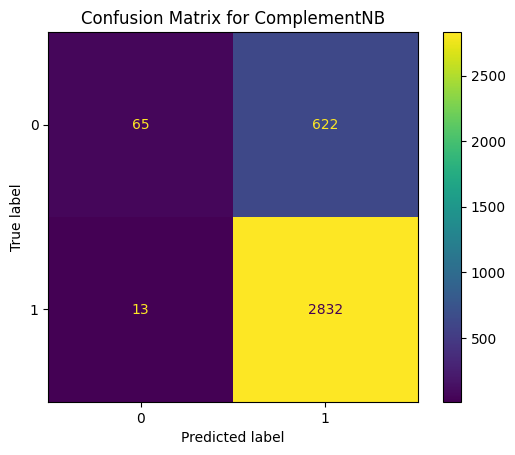

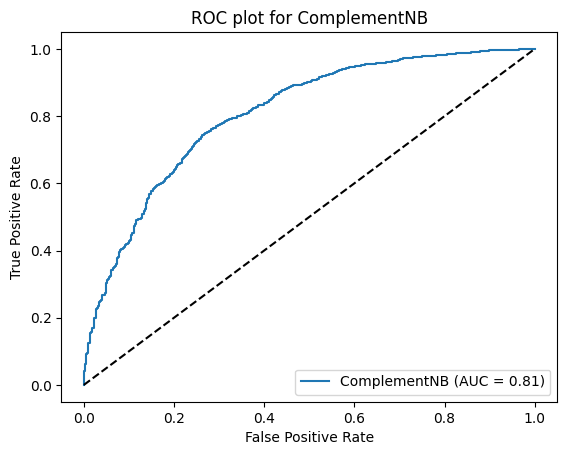

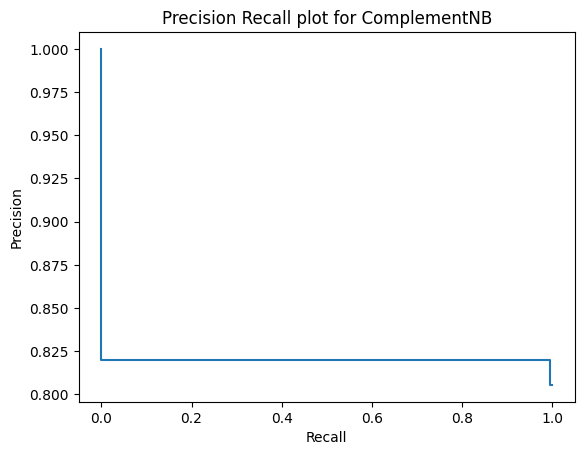


RandomForestClassifier
Accuracy: 0.81 
Detail:
              precision    recall  f1-score   support

           0       0.60      0.04      0.07       687
           1       0.81      0.99      0.89      2845

    accuracy                           0.81      3532
   macro avg       0.71      0.52      0.48      3532
weighted avg       0.77      0.81      0.73      3532



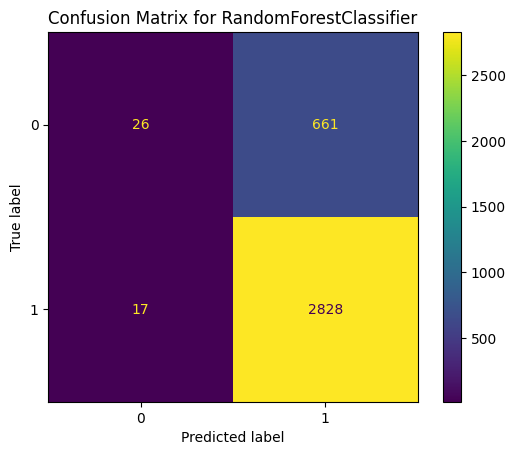

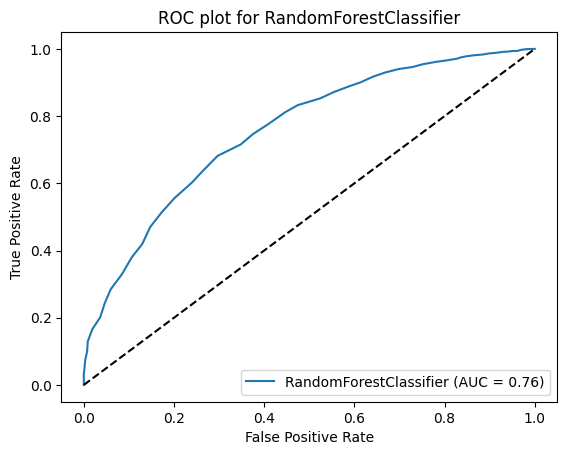

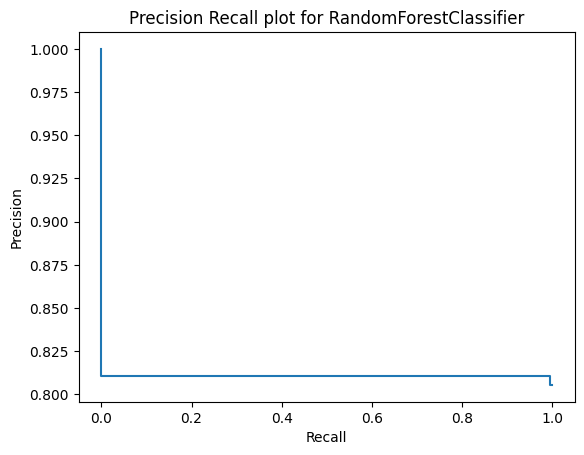


XGBoost
Accuracy: 0.94 
Detail:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       687
           1       0.95      0.98      0.96      2845

    accuracy                           0.94      3532
   macro avg       0.92      0.88      0.90      3532
weighted avg       0.94      0.94      0.94      3532



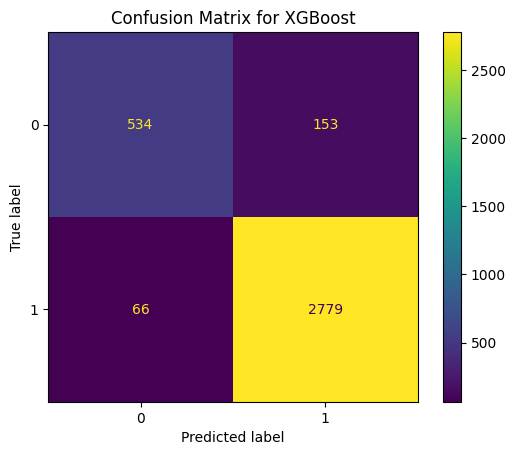

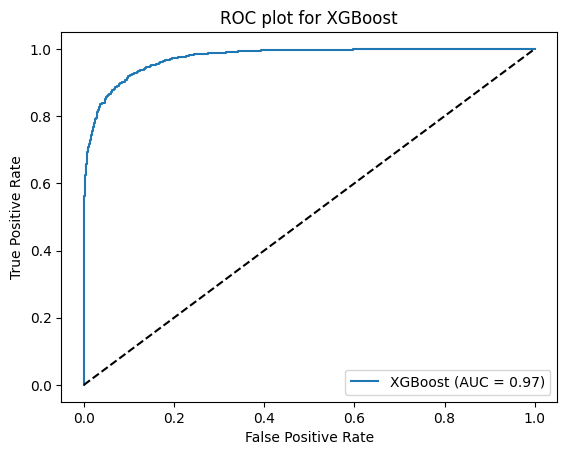

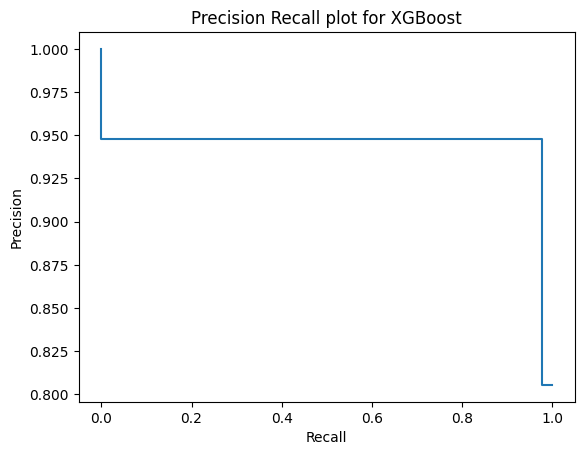

In [ ]:
for classifier in classifiers:
  y_pred = classifiers[classifier].predict(encodings[classifier]['X_test'])
  predicted_prob = classifiers[classifier].predict_proba(encodings[classifier]['X_test'])[:, 1]
  print(f"\n{classifier}")
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:",  round(accuracy, 2), "\nDetail:")
  report = classification_report(y_true=y_test, y_pred=y_pred, labels=[0, 1])
  print(report)
  report = classification_report(y_true=y_test, y_pred=y_pred, output_dict=True)
  cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title(f"Confusion Matrix for {classifier}")
  plt.show()
  print()
  fpr, tpr, _ = roc_curve(y_test.ravel(), predicted_prob.ravel()) # For micro add .ravel() to the inputs
  temp1 = pd.DataFrame({"fpr": fpr, "tpr": tpr, "model": classifier})
  roc_df = pd.concat([roc_df, temp1], ignore_index=True)
  roc_auc = auc(fpr, tpr)
  metrics['recall'].append(report['macro avg']['recall'])
  metrics['precision'].append(report['macro avg']['precision'])
  metrics['f1-score'].append(report['macro avg']['f1-score'])
  metrics['accuracy'].append(report["accuracy"])
  metrics['roc-auc'].append(roc_auc)
  disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name=classifier)
  disp.plot()
  plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
  plt.title(f"ROC plot for {classifier}")
  plt.show()
  print()
  precision, recall, _ = precision_recall_curve(y_test, y_pred)
  temp2 = pd.DataFrame({"precision": precision, "recall": recall, "model": classifier})
  prec_rec_df = pd.concat([prec_rec_df, temp2], ignore_index=True)
  disp = PrecisionRecallDisplay(precision=precision, recall=recall)
  disp.plot()
  plt.title(f"Precision Recall plot for {classifier}")
  plt.show()

In [ ]:
# time will be a metric performance as requested
times = {}
times["ComplementNB"] = all_times["tokenization"] + all_times["Tfidf_encoding"] + all_times['Tfidf_training'] + all_times['ComplementNB_training']
times["RandomForestClassifier"] = all_times["tokenization"] + all_times["Doc2Vec_encoding"] + all_times["Doc2Vec_training"] + all_times['RandomForestClassifier_training']
times["XGBoost"] = all_times["Bert_encoding"] + all_times['XGBoost_training']


times = pd.DataFrame({"model": times.keys(), "time": times.values()})

print(times)


metrics = pd.DataFrame({"model": times["model"].values,
                        "accuracy": metrics["accuracy"],
                        "recall": metrics["recall"],
                        "precision": metrics["precision"],
                        "f1-score": metrics["f1-score"],
                        "roc-auc": metrics["roc-auc"],
                        "time": times["time"].values})

                    model        time
0            ComplementNB   23.849834
1  RandomForestClassifier   91.063648
2                 XGBoost  497.349632


Provide a rationale for the choice of metrics - **Use at most 3 sentences.**

[comment]: <> (#SHOW_CELL#)

We first report time, as explicitly requested by the company, and accuracy as the most intuitive of the metrics, then we show the precision and recall values (F1 score also for completeness) because they are potentially useful, for example, in situations where the company needs to focus on minimizing false negatives to avoid producing underappreciated products (optimizing resource use) or to try to understand which products have real value to the customer more accurately (minimizing false positives).

The confusion matrix is useful in highlighting the inaccuracy in prediction due to the imbalanceness of the dataset and to gain a general insight.

Finally, the ROC curve allows for a good graphical comparison of the performance of the various models, giving a good measure (along with the AUC score) of the separation ability in the two classes and providing an immediate comparison with the trivial random classification (bisector of the two axes).


### 1.1.6
Provide the company with all the information it needs to choose the pipeline it prefers.

Metrics:


,model,accuracy,recall,precision,f1-score,roc-auc,time
0,ComplementNB,0.820215,0.545022,0.826626,0.534562,0.807689,23.849834
1,RandomForestClassifier,0.808041,0.515935,0.707599,0.482096,0.757089,91.063648
2,XGBoost,0.937995,0.877047,0.918909,0.895964,0.974108,497.349632


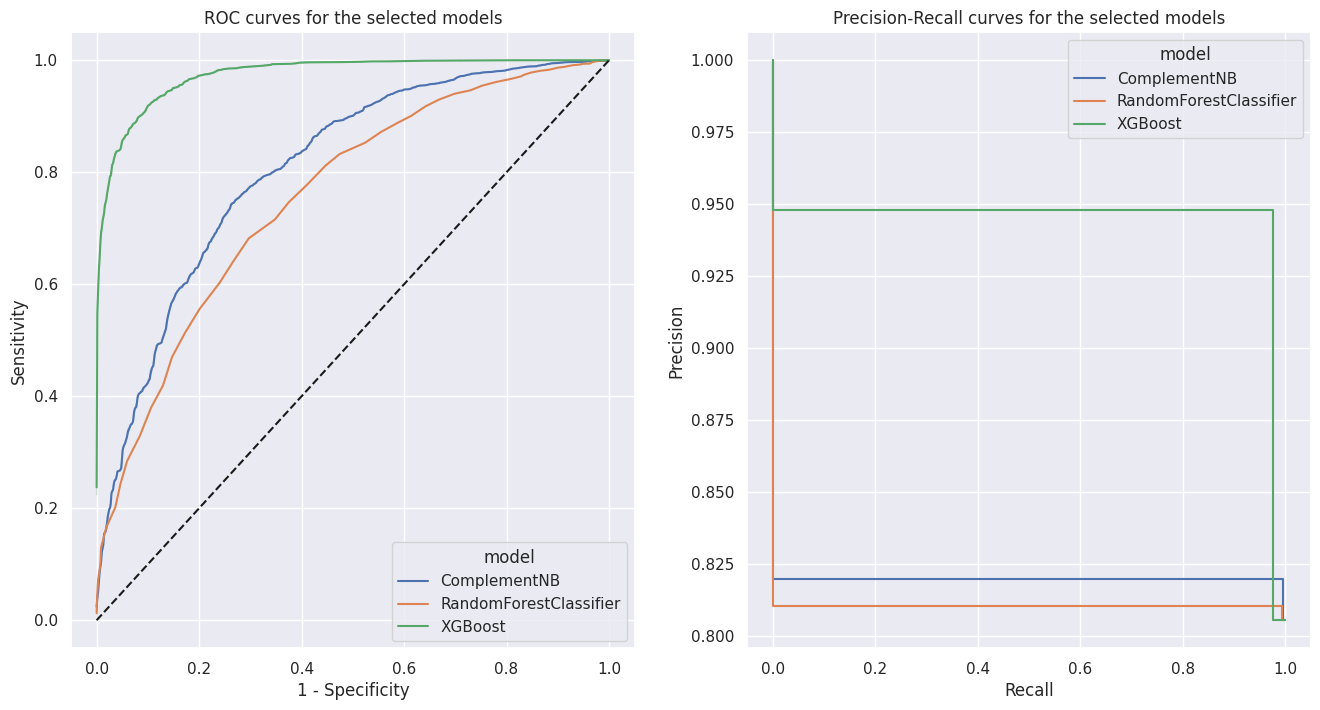

In [ ]:
print("Metrics:")
display(metrics)

print()

sns.set()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
sns.lineplot(data=roc_df, x="fpr", y="tpr", hue="model", ax=ax1)
ax1.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax1.set_ylabel("Sensitivity")
ax1.set_xlabel("1 - Specificity")
ax1.set_title("ROC curves for the selected models")
sns.lineplot(data=prec_rec_df, x="recall", y="precision", hue="model", drawstyle="steps-pre", ax=ax2)
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")
ax2.set_title("Precision-Recall curves for the selected models")
plt.show()

Describe what you have supplied and why - **Use at most 3 sentences.**

[comment]: <> (#SHOW_CELL#)

We thought it was only correct to grant an overview as broad as possible to the company so as to offer metrics that, as we mentioned earlier, can give useful information based on contingencies and possible critical success factors to relate to.

In addition to Accuracy, Recall and Precision, we decided to include the measure of total processing and construction time of the various pipelines, as time is also a critical variable (e.g. time to market, consumer sentiment response time, etc...) and expressly requested.

Finally, we have reported the ROC curve that allows us to summarize and graphically compare the performance of the three pipelines, and the precision-recall curve that highlights the fact that the best algorithm is the only one that can correctly handle data set imbalance without further tuning of hyperparameters.


Also, explain how the company could decide between the classifiers you have produced - **Use at most 3 sentences.**

[comment]: <> (#SHOW_CELL#)

The proposed classifiers all show good performance, but in particular the Naive Bayes Complement stands out for its speed (as we expected) and should be considered as the best model when the time variable assumes crucial importance.

The Random Forest, on the other hand, despite combining with Word2Vec encoding, fails to outperform in accuracy our baseline combination (Naive Bayes plus TF-IDF) and takes far longer, demonstrating how more complex models do not always perform better.

XGBoost yields excellent metrics, excelling by far among all algorithms, both as an extremely effective model and because in combination with BERT's pre-trained embeddings (in a multi-lingual version), and should be selected when the company identifies customer satisfaction rather than reaction time as the key factor in its analysis of decisional strategy.


## Part 1.2

### 1.2.1
Consider a scenario in which you have a set of words.

These must be transformed into a representation suitable for Machine Learning.

However, each representation has a fixed limit $K$.

Comment on how 3 word representations would behave in this scenario.

**Use at most 3 sentences.**

In the case of TF-IDF I cannot set the output dimensionality at encoding since this depends on the number of terms in the reference vocabulary, consequently I will have to choose whether to directly reduce the vocabulary to the most frequent terms or to opt for a PCA for choosing the most important terms in the collection, and in either case it will result in a loss of information (some terms will not be considered).

In word2vec, dimensionality  is a hyperparameter to be set, and in this case, for smaller dimensions, the encoder loses specificity in considering correlations between words in the same sentence.

Finally, in order to meet the K limit with embedding in BERT, being pre-trained models, we are forced to opt for models that meet the required dimensionality or we must actually pursue a reduction in dimensionality of the output, in any case losing part of the model's ability to appreciate the variety of contexts of the same term.




# Part 2 - Deep Learning model

Import here **ALL** the Python packages that you need for Part 2.

In [ ]:
import copy
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim import Adam

# If we want to perform the encoding inside the model -> suggested for gradient update and tune encoding
# But now we want to use the Bert encoding without tune it
from transformers import AutoTokenizer, AutoModel

from typing import Tuple

## Part 2.1
You have to use the same data as in Part 1, but you can use whatever adjustments you have made to it (only Part 1.1.2).

### 2.1.1
Prepare the data structures you will need.

In [ ]:
torch.manual_seed(seed)

# define a class for our dataset (take only the interesting info)
class CustomDataSet(Dataset):
  def __init__(self, df, column, target):
    self.column = column
    self.target = target
    self.dataframe = df[[column, target]]

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    row = self.dataframe.iloc[[idx]]
    input_tokens = row[self.column].values[0]
    label = row[self.target].values[0]
    return  torch.tensor(input_tokens), torch.tensor(label, dtype=torch.float32)


# We perform the encoding of the dataframe
bert_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
df['encoded'] = df.apply(lambda row: bert_model.encode([[row.title, row.review_text]]), axis=1)

# We build the Dataset
dataset = CustomDataSet(df, "encoded", "label")

In [ ]:
BATCH_SIZE = 128
# init a generator
generator = torch.Generator().manual_seed(seed)
training_set, test_set, validation_set = random_split(dataset, [0.8, 0.1, 0.1], generator)

# build a dataloader for each set
train_dl = DataLoader(training_set , batch_size=BATCH_SIZE, shuffle=True)#, collate_fn=collate_batch)
test_dl = DataLoader(test_set , batch_size=BATCH_SIZE, shuffle=False)#, collate_fn=collate_batch)
val_dl = DataLoader(validation_set , batch_size=BATCH_SIZE, shuffle=False)#, collate_fn=collate_batch)

Briefly explain relevant parts of your code - **Use at most 3 sentences.**

[comment]: <> (#SHOW_CELL#)

From the pytorch `Dataset` class we have defined our personal dataset, which is initialized with a dataframe (already preprocessed and encoded) then we have splitted it in train, test and validation set (80%, 10%, 10%) and from these we have initialized the train, test and validation dataloader (with equal batch size set to 128).

We have decided to not encode the dataframe in the our model because we wanted to use the same Bert encodings used in the previous section.

For this reason getting the gradient and performing the backpropagation was not important (and not feasible for our GPU becuase of how many parameters Bert has).

### 2.1.2
Define your model

In [ ]:
class OurNet(nn.Module):
  def __init__(self, expansion_dim, n_hidden, input_size=768, output_size=1, dropout=0.5):
    super(OurNet, self).__init__()
    self.n_hidden = n_hidden
    self.drop = nn.Dropout(dropout)
    self.gelu = nn.GELU()
    self.hidden_block = nn.Sequential(nn.Linear(expansion_dim, expansion_dim),
                                      self.gelu,
                                      self.drop,
                                      nn.Linear(expansion_dim, expansion_dim))

    self.layers = self.get_clones(self.hidden_block, self.n_hidden)
    self.init_layer = nn.Linear(input_size, expansion_dim)
    self.output_layer = nn.Linear(expansion_dim, output_size)

  def get_clones(self, module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

  def forward(self, x):
    x = self.gelu(self.init_layer(x))
    for i in range(self.n_hidden):
      x = self.layers[i](x)
      x = self.gelu(x)
    return self.output_layer(x)

Briefly explain relevant parts of your code - **Use at most 3 sentences.**

[comment]: <> (#SHOW_CELL#)

Our model is a simple Feed Forward NeuralNetwork that uses Bert encodings as input.

The FFN is composed of the init layer (that will take the bert encodings), the output layer and $n$ (which can be set) hidden modules which consist of two linear layers (with `expansion_dim` neurons each) connected by an activation function.

We have decided to add dropout between the layers of each hidden block, and use as activation function `nn.GELU()` (which is differentiable in 0).

### 2.1.3
Train and optimize your model

In [ ]:
def train(model, train_dl, val_dl, learning_rate, epochs, device) -> Dict[str, List[float]]:
  model = model.to(device)
  criterion = nn.BCEWithLogitsLoss().to(device)
  optimizer = Adam(model.parameters(), lr = learning_rate)
  results = defaultdict(list)
  for epoch in tqdm(range(epochs)):
    model.train()
    total_acc_train = total_loss_train = 0
    for train_input, train_label in train_dl:
      optimizer.zero_grad()
      x_train, y_train = train_input.to(device), train_label.to(device)
      y_logits = model(x_train).squeeze()
      y_pred = torch.round(torch.sigmoid(y_logits))
      loss = criterion(y_logits, y_train)
      acc = (torch.eq(y_train, y_pred).sum().item() / len(y_pred)) * 100
      total_loss_train += loss.item()
      total_acc_train += acc
      loss.backward()
      optimizer.step()
    model.eval()
    total_acc_val = total_loss_val = 0
    with torch.inference_mode():
      for val_input, val_label in val_dl:
        x_val, y_val = val_input.to(device), val_label.to(device)
        val_logits = model(x_val).squeeze()
        val_pred = torch.round(torch.sigmoid(val_logits))
        val_loss = criterion(val_logits, y_val)
        val_acc = (torch.eq(y_val, val_pred).sum().item() / len(val_pred)) * 100
        total_loss_val += val_loss.item()
        total_acc_val += val_acc
    if epoch % 10 == 0: print(f"Epochs: {epoch+1} | Train Loss: {total_loss_train/len(train_dl): .3f} | Train Accuracy: {total_acc_train / len(train_dl): .3f} | Val Loss: {total_loss_val / len(val_dl): .3f} | Val Accuracy: {total_acc_val / len(val_dl): .3f}")
    results['epochs'].append(epoch+1)
    results['train_loss'].append(round(total_loss_train/len(train_dl), 3))
    results['train_accuracy'].append(round(total_acc_train / len(train_dl), 3))
    results['val_loss'].append(round(total_loss_val / len(val_dl), 3))
    results['val_accuracy'].append(round(total_acc_val / len(val_dl), 3))
  return results

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed)

EPOCHS = 40
model = OurNet(expansion_dim=768*2, n_hidden=4, dropout=0.5)
LR = 1e-3

results = train(model, train_dl, val_dl, LR, EPOCHS, device)

  0%|          | 0/40 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.293 | Train Accuracy:  88.933 | Val Loss:  0.214 | Val Accuracy:  91.622
Epochs: 11 | Train Loss:  0.186 | Train Accuracy:  92.887 | Val Loss:  0.184 | Val Accuracy:  92.459
Epochs: 21 | Train Loss:  0.214 | Train Accuracy:  91.754 | Val Loss:  0.205 | Val Accuracy:  91.856
Epochs: 31 | Train Loss:  0.143 | Train Accuracy:  94.205 | Val Loss:  0.171 | Val Accuracy:  92.697


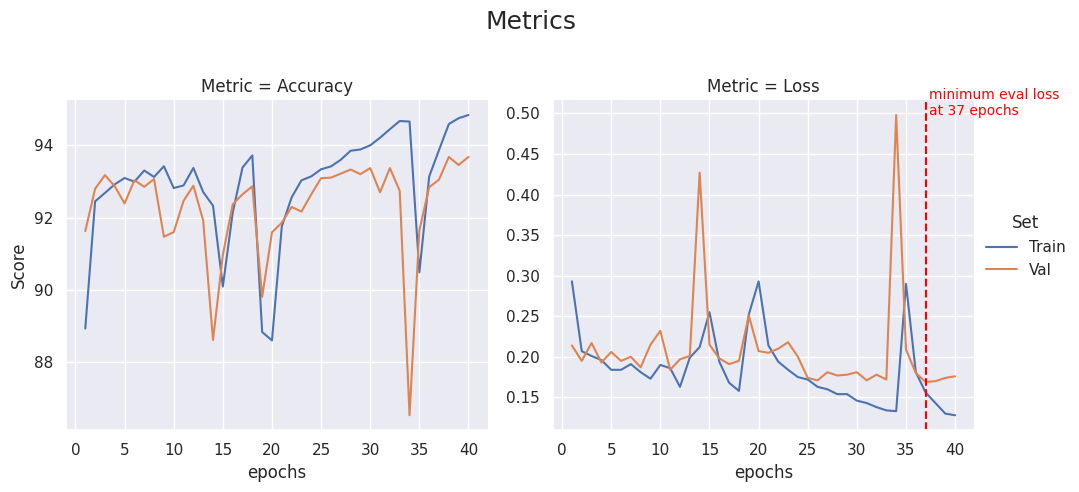

In [ ]:
def plot_results(results: Dict[str, List[float]],
                 epochs: str,
                 scores_columns: List[str]) -> int:

  temp = pd.DataFrame(results)

  minimum = temp[temp.val_loss == temp.val_loss.min()].epochs.values[0]
  maximum = temp.val_loss.max()

  temp = pd.melt(temp, id_vars=[epochs],
                 value_vars=scores_columns, var_name='Set', value_name='Score')

  temp['Metric'] = temp['Set'].apply(lambda x: x.split('_')[1].capitalize())
  temp['Set'] = temp['Set'].apply(lambda x: x.split('_')[0].capitalize())

  rel = sns.relplot(temp, x=epochs, y="Score", col="Metric", hue="Set", kind="line", facet_kws={'sharey': False, 'sharex': True})
  rel.fig.suptitle('Metrics', fontsize=18)
  rel.fig.subplots_adjust(top=.8)
  plt.axvline(minimum, color='red', linestyle="--")
  plt.text(minimum+0.3, maximum, f'minimum eval loss\nat {minimum} epochs', color="red", fontsize = 10)
  plt.show()
  return minimum

best = plot_results(results,
                    epochs='epochs',
                    scores_columns=['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'])

Briefly explain relevant parts of your code - **Use at most 3 sentences.**

[comment]: <> (#SHOW_CELL#)

In this section we have defined the training loop in which we train our model and validate it on the validation set (in this way it is possible to implement early stopping using the validation loss, we didn't implement it for the rescricted number of rows).

Being in a binary classification case we have used the Binary Cross Entropy, in our particular case we have used `nn.BCEWithLogitsLoss()` because we have decide to work with the pure logits (in case we wanted to work with the resulting labels, which we can get using `torch.round(torch.sigmoid(y_logits))`,  we should use `nn.BCELoss()`)

In the training loop we measure and return the accuracy and loss in both training and validation set, because we're going to pass these as input to another function `plot_results()` which will plot our model behavior in terms of those metrics (for both training and validation set).

### 2.1.4
Show the performance of your model

In [ ]:
def eval(model, test_dl, device, batch) -> Tuple[float, float, List[float], List[float]]:
  model = model.to(device)
  criterion = nn.BCEWithLogitsLoss().to(device)
  results = defaultdict(list)
  model.eval()
  total_acc_val = total_loss_val = 0
  y_pred = np.array([])
  y_true = np.array([])
  with torch.inference_mode():
    for test_input, test_label in test_dl:

      x_test, y_test = test_input.to(device), test_label.to(device)

      test_logits = model(x_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      y_true = np.hstack((y_true, y_test.cpu().numpy()))
      y_pred = np.hstack((y_pred, test_pred.cpu().numpy()))

      loss = criterion(test_logits, y_test).item()
      acc = (torch.eq(y_test, test_pred).sum().item() / len(test_pred)) * 100

  return loss, acc, y_true, y_pred


torch.manual_seed(seed)
model = OurNet(expansion_dim=768*2, n_hidden=4, dropout=0.5)

# Train to the best epoch
train(model, train_dl, val_dl, LR, best, device)

loss, accuracy, y_true, predictions = eval(model, test_dl, device, BATCH_SIZE)



print()
print(f"{loss = :.3f}, {accuracy = :.2f}%")

  0%|          | 0/37 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.293 | Train Accuracy:  88.933 | Val Loss:  0.214 | Val Accuracy:  91.622
Epochs: 11 | Train Loss:  0.186 | Train Accuracy:  92.887 | Val Loss:  0.184 | Val Accuracy:  92.459
Epochs: 21 | Train Loss:  0.214 | Train Accuracy:  91.754 | Val Loss:  0.205 | Val Accuracy:  91.856
Epochs: 31 | Train Loss:  0.143 | Train Accuracy:  94.205 | Val Loss:  0.171 | Val Accuracy:  92.697

loss = 0.145, accuracy = 95.10%


Classification report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80       341
           1       0.94      0.97      0.96      1425

    accuracy                           0.93      1766
   macro avg       0.91      0.86      0.88      1766
weighted avg       0.93      0.93      0.93      1766



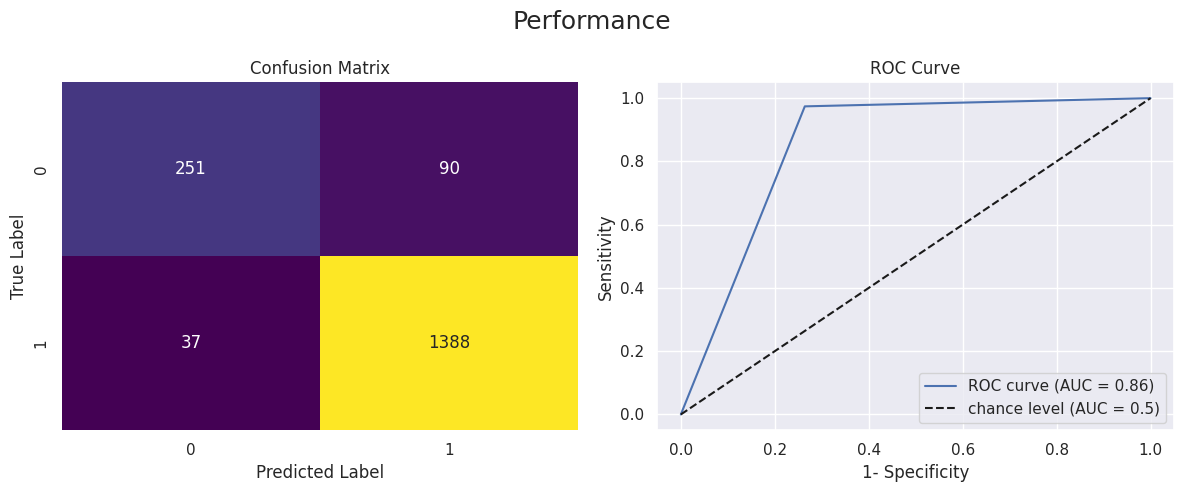

In [ ]:
def show_performance(y_test, y_pred):

    # Classification report
    print("Classification report:")
    print(classification_report(y_true=y_test, y_pred=y_pred, labels=[0, 1]))

    # Get ROC, auc and Confusion Matrix
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Confusion Matrix plot
    sns.heatmap(cm, annot=True, cmap='viridis', fmt='d', cbar=False, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # ROC plot
    axes[1].plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    axes[1].plot([0, 1], [0, 1], 'k--', label="chance level (AUC = 0.5)")
    axes[1].set_title('ROC Curve')
    axes[1].set_xlabel('1- Specificity')
    axes[1].set_ylabel('Sensitivity')
    axes[1].legend(loc='lower right')

    fig.suptitle("Performance", fontsize=18)
    plt.tight_layout()
    plt.show()




show_performance(y_true, predictions)

Briefly explain relevant parts of your code - **Use at most 3 sentences.**

[comment]: <> (#SHOW_CELL#)

We have define an `eval()` function that performs an eval loop over the `test_dl` (the DataLoader built over the test set): this function returns the loss, accuracy and the values for the label ground truth and predictions.

Then we have defined a second funtion `show_performance()`, that prints the classification report and display both confusion matrix and ROC curve (with AUC score).

### 2.1.5
Provide an ablation study on at least one and at most three parameters.

  0%|          | 0/40 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.296 | Train Accuracy:  88.117 | Val Loss:  0.202 | Val Accuracy:  92.206
Epochs: 11 | Train Loss:  0.157 | Train Accuracy:  93.906 | Val Loss:  0.194 | Val Accuracy:  93.158
Epochs: 21 | Train Loss:  0.123 | Train Accuracy:  95.244 | Val Loss:  0.192 | Val Accuracy:  93.255
Epochs: 31 | Train Loss:  0.072 | Train Accuracy:  97.144 | Val Loss:  0.250 | Val Accuracy:  94.375


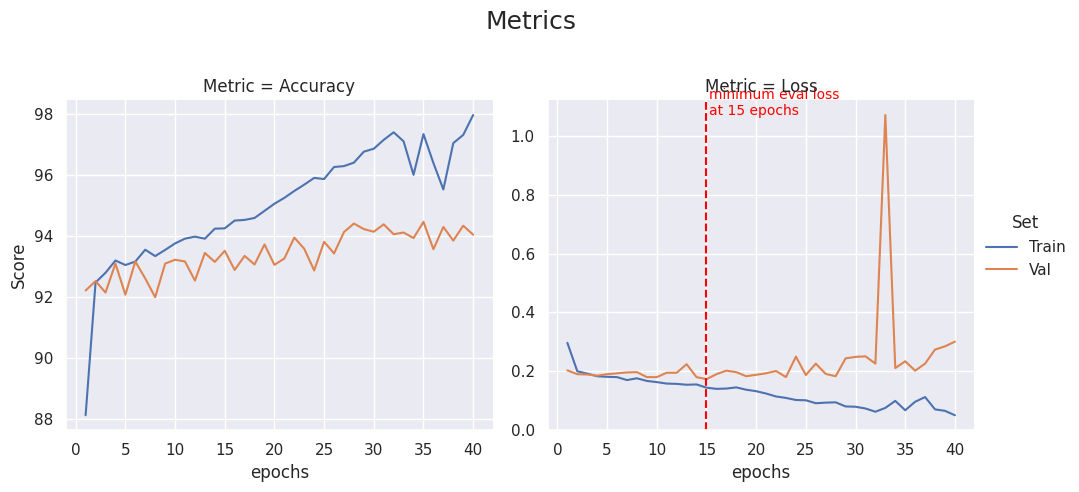

  0%|          | 0/15 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.296 | Train Accuracy:  88.117 | Val Loss:  0.202 | Val Accuracy:  92.206
Epochs: 11 | Train Loss:  0.157 | Train Accuracy:  93.906 | Val Loss:  0.194 | Val Accuracy:  93.158
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       341
           1       0.96      0.96      0.96      1425

    accuracy                           0.93      1766
   macro avg       0.90      0.89      0.89      1766
weighted avg       0.93      0.93      0.93      1766



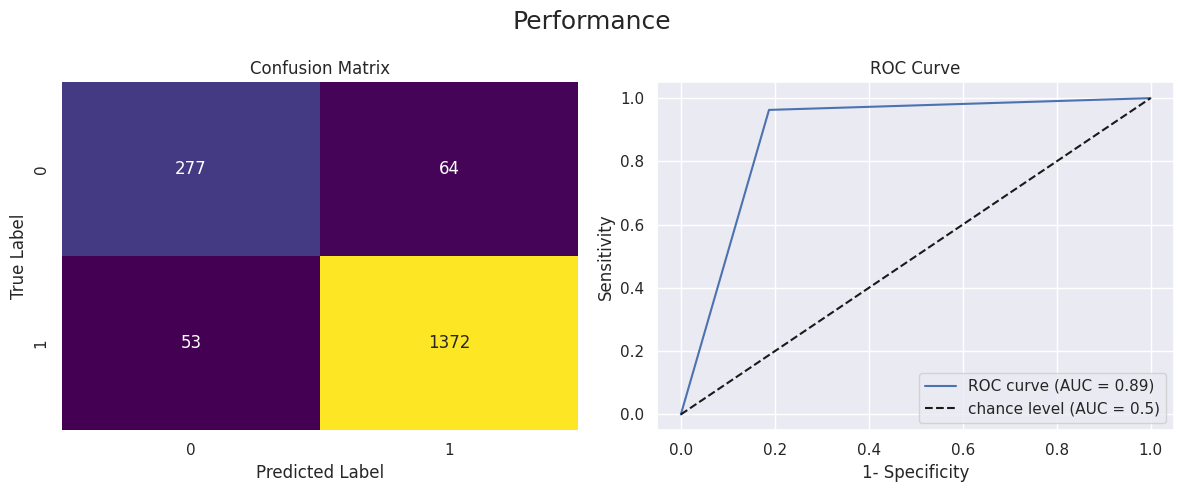

In [ ]:
torch.manual_seed(seed)

model = OurNet(expansion_dim=768, n_hidden=4, dropout=0.5)

results = train(model, train_dl, val_dl, LR, EPOCHS, device)

best = plot_results(results,
                    epochs='epochs',
                    scores_columns=['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'])

torch.manual_seed(seed)
model = OurNet(expansion_dim=768, n_hidden=4, dropout=0.5)

# Train to the best epoch
train(model, train_dl, val_dl, LR, best, device)

loss, accuracy, y_true, predictions = eval(model, test_dl, device, BATCH_SIZE)

show_performance(y_true, predictions)

  0%|          | 0/40 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.249 | Train Accuracy:  90.524 | Val Loss:  0.198 | Val Accuracy:  92.611
Epochs: 11 | Train Loss:  0.151 | Train Accuracy:  93.935 | Val Loss:  0.171 | Val Accuracy:  93.214
Epochs: 21 | Train Loss:  0.090 | Train Accuracy:  96.333 | Val Loss:  0.191 | Val Accuracy:  93.407
Epochs: 31 | Train Loss:  0.050 | Train Accuracy:  97.996 | Val Loss:  0.318 | Val Accuracy:  94.553


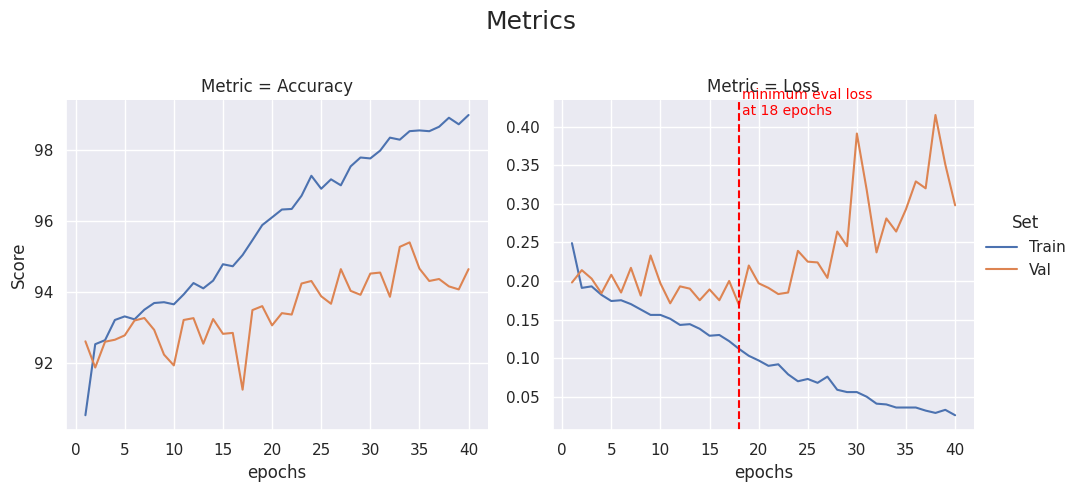

  0%|          | 0/18 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.249 | Train Accuracy:  90.524 | Val Loss:  0.198 | Val Accuracy:  92.611
Epochs: 11 | Train Loss:  0.151 | Train Accuracy:  93.935 | Val Loss:  0.171 | Val Accuracy:  93.214
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       341
           1       0.96      0.96      0.96      1425

    accuracy                           0.93      1766
   macro avg       0.90      0.89      0.89      1766
weighted avg       0.93      0.93      0.93      1766



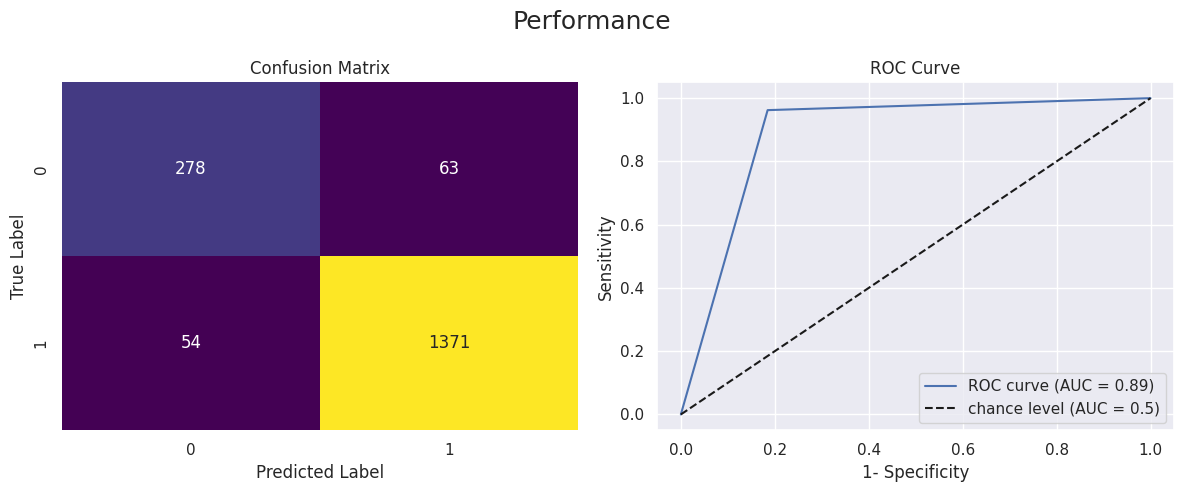

In [ ]:
torch.manual_seed(seed)

model = OurNet(expansion_dim=768*2, n_hidden=2, dropout=0.5)

results = train(model, train_dl, val_dl, LR, EPOCHS, device)

best = plot_results(results,
                    epochs='epochs',
                    scores_columns=['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'])

torch.manual_seed(seed)
model = OurNet(expansion_dim=768*2, n_hidden=2, dropout=0.5)

# Train to the best epoch
train(model, train_dl, val_dl, LR, best, device)

loss, accuracy, y_true, predictions = eval(model, test_dl, device, BATCH_SIZE)

show_performance(y_true, predictions)


  0%|          | 0/40 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.253 | Train Accuracy:  89.346 | Val Loss:  0.200 | Val Accuracy:  92.373
Epochs: 11 | Train Loss:  0.152 | Train Accuracy:  93.978 | Val Loss:  0.171 | Val Accuracy:  93.047
Epochs: 21 | Train Loss:  0.086 | Train Accuracy:  96.630 | Val Loss:  0.160 | Val Accuracy:  94.330
Epochs: 31 | Train Loss:  0.038 | Train Accuracy:  98.726 | Val Loss:  0.183 | Val Accuracy:  94.847


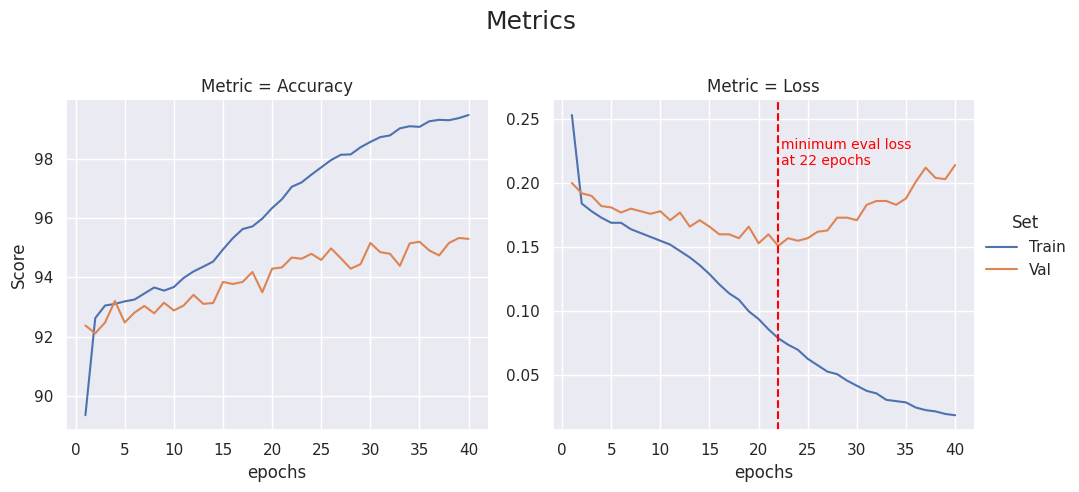

  0%|          | 0/22 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  0.253 | Train Accuracy:  89.346 | Val Loss:  0.200 | Val Accuracy:  92.373
Epochs: 11 | Train Loss:  0.152 | Train Accuracy:  93.978 | Val Loss:  0.171 | Val Accuracy:  93.047
Epochs: 21 | Train Loss:  0.086 | Train Accuracy:  96.630 | Val Loss:  0.160 | Val Accuracy:  94.330
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       341
           1       0.96      0.96      0.96      1425

    accuracy                           0.94      1766
   macro avg       0.90      0.89      0.90      1766
weighted avg       0.94      0.94      0.94      1766



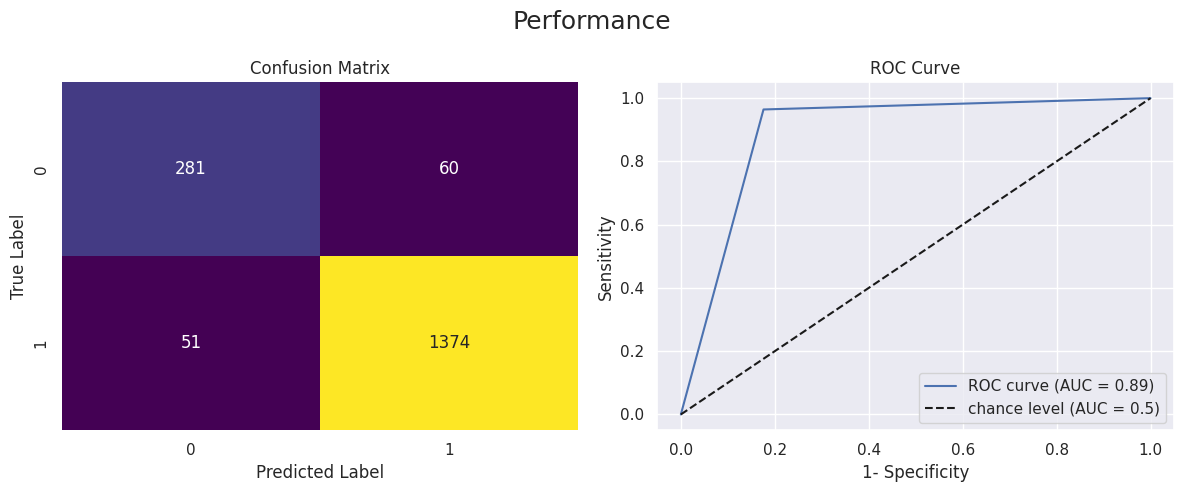

In [ ]:
torch.manual_seed(seed)

model = OurNet(expansion_dim=768*2, n_hidden=0, dropout=0.5)

results = train(model, train_dl, val_dl, LR, EPOCHS, device)

best = plot_results(results,
                    epochs='epochs',
                    scores_columns=['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'])

torch.manual_seed(seed)
model = OurNet(expansion_dim=768*2, n_hidden=0, dropout=0.5)

# Train to the best epoch
train(model, train_dl, val_dl, LR, best, device)

loss, accuracy, y_true, predictions = eval(model, test_dl, device, BATCH_SIZE)

show_performance(y_true, predictions)

Comment the ablation study - **Use at most 3 sentences.**

[comment]: <> (#SHOW_CELL#)

We decide to propose an ablation study in which we change the parameters inherent to the number of neurons and the number of hidden layers, noting how the decrease of either parameter in each of the cases considered causes a more or less important overfitting.

In two cases we re-propose the same initial number of neurons, but we reduce from time to time in number of hidden layers until we remove all hidden layers and show the results of a basic neural network which, thanks to the work done in the embedding phase by BERT, manages to achieve very good performance however overfitting very soon.

In another ablation study, on the other hand, we decrease the number of neurons and again the model overfits early (as visible can be seen by the opposite trends two curves for training set and validation for both accuracy and loss) indicating how the original model can potentially improve its performance by training it longer (it still manages to generalize well).


## Part 2.2

### 2.2.1
How would a Deep Learning model (of the kind we have seen) behave in the case where a word was never seen during training?
Answer on both practical and theoretical aspects.

**Use at most 3 sentences.**

The deep learning models faced always fail to properly handle the problem of OOV words (out-of-vocabulary i.e., words not seen during training) as they are often simply ignored and encoded with a special "unkown" token, but at the same time, as explained in [this article](https://arxiv.org/abs/2007.07318), the performance in these cases can vary greatly depending on the encoding technique used by the model and depending on the specific task considered.

In general, models that use "whole-word" encoding (such as bag-of-words or word2vec) perform worse (in the case where there are many OOV words) than models such as BERT and GPT that use "subword" encoding and drastically reduce the probability of finding an OOV word by trying to break it down into subword units that are in its vocabulary.

In any case, OOV words are still a problem in model design, and although there are more or less effective solutions, often in attempting to cope with this issue the neural network loses effectiveness in capturing the semantic meanings of words.
